# Neural Collaborative Filtering
1. [논문](https://arxiv.org/pdf/1708.05031.pdf)
2. Keras로 작성된 [저자 코드](https://github.com/hexiangnan/neural_collaborative_filtering)
3. 논문은 0과 1로 user-item interaction으로 matrix을 나타내고 학습했으나, 이번 실습에서는 rating을 직접 예측하고, loss를 구해보는 것을 진행한다

## Configuration

In [3]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import math
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
!git clone https://github.com/lovit/kmrd
!python setup.py install

Cloning into 'kmrd'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 298 (delta 38), reused 69 (delta 33), pack-reused 214
Receiving objects: 100% (298/298), 194.05 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (135/135), done.
python: can't open file '/Users/jinsuc28/Documents/GitHub/fastcampus-RecSys/04-Recommender-System-with-DeepLearning/setup.py': [Errno 2] No such file or directory


## Load Dataset
- KMRD 데이터셋 활용
- google colab의 경우 data path 다시 확인하기

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
data_path = 'kmrd/kmr_dataset/datafile/kmrd-small'

In [16]:
def read_data(data_path):
  df = pd.read_csv(os.path.join(data_path,'rates.csv'))
  train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)
  return train_df, val_df

In [17]:
# !nvidia-smi

In [18]:
# 학습할 영화 데이터 분석
train_df, val_df = read_data(data_path)

In [19]:
print(train_df.shape)
print(train_df.head())

(112568, 4)
         user  movie  rate        time
137023  48423  10764    10  1212241560
92868   17307  10170    10  1122185220
94390   18180  10048    10  1573403460
22289    1498  10001     9  1432684500
80155   12541  10022    10  1370458140


In [20]:
val_df.shape

(28142, 4)

<AxesSubplot:>

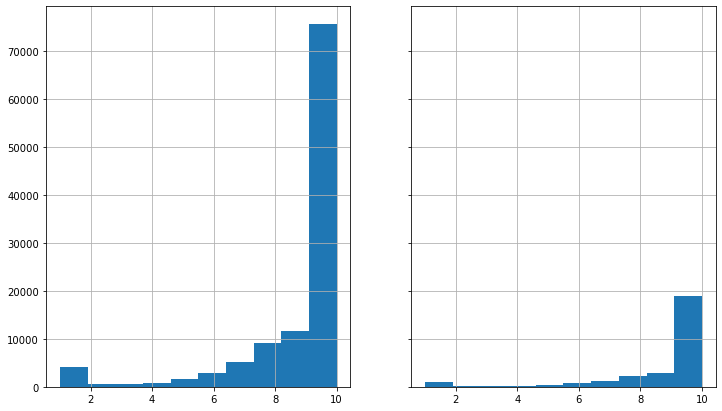

In [21]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12,7))
ax = ax.ravel()

train_df['rate'].hist(ax=ax[0])
val_df['rate'].hist(ax=ax[1])

In [22]:
train_df['rate'].describe()

count    112568.000000
mean          8.948369
std           2.114602
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64

## Load movie dataframe

In [23]:
# Load all related dataframe
movies_df = pd.read_csv(os.path.join(data_path, 'movies.txt'), sep='\t', encoding='utf-8')
movies_df = movies_df.set_index('movie')

castings_df = pd.read_csv(os.path.join(data_path, 'castings.csv'), encoding='utf-8')
countries_df = pd.read_csv(os.path.join(data_path, 'countries.csv'), encoding='utf-8')
genres_df = pd.read_csv(os.path.join(data_path, 'genres.csv'), encoding='utf-8')

# Get genre information
genres = [(list(set(x['movie'].values))[0], '/'.join(x['genre'].values)) for index, x in genres_df.groupby('movie')]
combined_genres_df = pd.DataFrame(data=genres, columns=['movie', 'genres'])
combined_genres_df = combined_genres_df.set_index('movie')

# Get castings information
castings = [(list(set(x['movie'].values))[0], x['people'].values) for index, x in castings_df.groupby('movie')]
combined_castings_df = pd.DataFrame(data=castings, columns=['movie','people'])
combined_castings_df = combined_castings_df.set_index('movie')

# Get countries for movie information
countries = [(list(set(x['movie'].values))[0], ','.join(x['country'].values)) for index, x in countries_df.groupby('movie')]
combined_countries_df = pd.DataFrame(data=countries, columns=['movie', 'country'])
combined_countries_df = combined_countries_df.set_index('movie')

movies_df = pd.concat([movies_df, combined_genres_df, combined_castings_df, combined_countries_df], axis=1)


In [24]:
movies_df.head()

,title,title_eng,year,grade,genres,people,country
movie,,,,,,,
10001,시네마 천국,"Cinema Paradiso , 1988",2013.0,전체 관람가,드라마/멜로/로맨스,"[4374, 178, 3241, 47952, 47953, 19538, 18991, ...","이탈리아,프랑스"
10002,빽 투 더 퓨쳐,"Back To The Future , 1985",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 8637, 5104, 9986, 7470, 9987]",미국
10003,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF/코미디,"[1076, 4603, 917, 5104, 391, 5106, 5105, 5107,...",미국
10004,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부/SF/판타지/코미디,"[1076, 4603, 1031, 5104, 10001, 5984, 10002, 1...",미국
10005,스타워즈 에피소드 4 - 새로운 희망,"Star Wars , 1977",1997.0,PG,판타지/모험/SF/액션,"[1007, 535, 215, 1236, 35]",미국


- 논문:  user latent vector + item latent vector
- 새롭게 생각할 수 있는 방법: user latent vector + item latent vector + etc vector (예시) meta information 

In [25]:
# 영화 데이터의 메타 정보를 확인한다
movieName_dict = movies_df.to_dict()['title']
genres_dict = movies_df.to_dict()['genres']

In [26]:
movies_df['genres']

movie
10001       드라마/멜로/로맨스
10002           SF/코미디
10003           SF/코미디
10004    서부/SF/판타지/코미디
10005     판타지/모험/SF/액션
             ...      
10995              스릴러
10996              코미디
10997               공포
10998    드라마/액션/모험/스릴러
10999        SF/드라마/공포
Name: genres, Length: 999, dtype: object

## Dataset Loader 

In [27]:
class DatasetLoader:
    def __init__(self, data_path):
        self.train_df, val_temp_df = read_data(data_path)

        self.min_rating = min(self.train_df.rate)
        self.max_rating = self.train_df.rate.max()

        self.unique_users = self.train_df.user.unique()
        self.num_users = len(self.unique_users)
        self.user_to_index = {original: idx for idx, original in enumerate(self.unique_users)}
        # 0 1 0 0 0 ... 0

        self.unique_movies = self.train_df.movie.unique()
        self.num_movies = len(self.unique_movies)
        self.movie_to_index = {original: idx for idx, original in enumerate(self.unique_movies)}

        self.val_df = val_temp_df[val_temp_df.user.isin(self.unique_users) & val_temp_df.movie.isin(self.unique_movies)]

    def generate_trainset(self):
        # user 0, 0, 0, 1,2, 3,3, -> movie: 0,0,0,0,0,0,
        X_train = pd.DataFrame({'user': self.train_df.user.map(self.user_to_index),
                     'movie': self.train_df.movie.map(self.movie_to_index)})
        y_train = self.train_df['rate'].astype(np.float32)

        return X_train, y_train

    def generate_valset(self):
        X_val = pd.DataFrame({'user': self.val_df.user.map(self.user_to_index),
                              'movie': self.val_df.movie.map(self.movie_to_index)})
        y_val = self.val_df['rate'].astype(np.float32)
        return X_val, y_val

## Model Structure
- 논문에서 제시한 모델 구조를 그대로 구현하고 영화 데이터로 실습해본다. 
- User Vector는 전체 영화 데이터에서 영화를 평가한 userid를 onehot vector로 나타낸 형태
- Item Vector는 전체 영화 데이터에 등장하는 영화의 id를 onehot vector로 나타낸 형태



In [28]:
class FeedForwardEmbedNN(nn.Module):

    def __init__(self, n_users, n_movies, hidden, dropouts, n_factors, embedding_dropout):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.movie_emb = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden_layers = nn.Sequential(*list(self.generate_layers(n_factors*2, hidden, dropouts)))
        self.fc = nn.Linear(hidden[-1], 1)

    def generate_layers(self, n_factors, hidden, dropouts):
        assert len(dropouts) == len(hidden)

        idx = 0
        while idx < len(hidden):
            if idx == 0:
                yield nn.Linear(n_factors, hidden[idx])
            else:
                yield nn.Linear(hidden[idx-1], hidden[idx])
            yield nn.ReLU()
            yield nn.Dropout(dropouts[idx])

            idx += 1

    def forward(self, users, movies, min_rating=0.5, max_rating=5):
        concat_features = torch.cat([self.user_emb(users), self.movie_emb(movies)], dim=1)
        x = F.relu(self.hidden_layers(concat_features))
        # 0과 1사이의 숫자로 나타낸다
        out = torch.sigmoid(self.fc(x))
        # rating으로 변환한다
        out = (out * (max_rating - min_rating)) + min_rating

        return out

    def predict(self, users, movies):
        # return the score
        output_scores = self.forward(users, movies)
        return output_scores

In [29]:
class BatchIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k * bs:(k + 1) * bs], self.y[k * bs:(k + 1) * bs]


In [30]:
def batches(X, y, bs=32, shuffle=True):
    for x_batch, y_batch in BatchIterator(X, y, bs, shuffle):
        x_batch = torch.LongTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        yield x_batch, y_batch.view(-1, 1)

## Train model
데이터셋과 모델 학습에 필요한 configuration을 입력하고, 학습을 하는 함수를 만든다
configuration을 바꾸면서 모델의 성능을 측정해볼 수 있다. 

In [31]:
def model_train(ds, config):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    X_train, y_train = ds.generate_trainset()
    X_valid, y_valid = ds.generate_valset()
    print(f'TrainSet Info: {ds.num_users} users, {ds.num_movies} movies')

    model = FeedForwardEmbedNN(
        n_users=ds.num_users, n_movies=ds.num_movies,
        n_factors=config['num_factors'], hidden=config['hidden_layers'],
        embedding_dropout=config['embedding_dropout'], dropouts=config['dropouts']
    )
    model.to(device)

    batch_size = config['batch_size']
    num_epochs = config['num_epochs']
    max_patience = config['total_patience']
    num_patience = 0
    best_loss = np.inf

    criterion = nn.MSELoss(reduction='sum')
    criterion.to(device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    result = dict()
    for epoch in tqdm(range(num_epochs)):
        training_loss = 0.0
        for batch in batches(X_train, y_train, shuffle=True, bs=batch_size):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # with torch.no_grad() 와 동일한 syntax 입니다
            with torch.set_grad_enabled(True):
                outputs = model(x_batch[:, 0], x_batch[:, 1], ds.min_rating, ds.max_rating)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
            training_loss += loss.item()
        result['train'] = training_loss / len(X_train)

        # Apply Early Stopping criteria and save best model params
        val_outputs = model(torch.LongTensor(X_valid.user.values).to(device),
                            torch.LongTensor(X_valid.movie.values).to(device), ds.min_rating, ds.max_rating)
        val_loss = criterion(val_outputs.to(device), torch.FloatTensor(y_valid.values).view(-1, 1).to(device))
        result['val'] = float((val_loss / len(X_valid)).data)

        if val_loss < best_loss:
            print('Save new model on epoch: %d' % (epoch + 1))
            best_loss = val_loss
            result['best_loss'] = val_loss
            torch.save(model.state_dict(), config['save_path'])
            num_patience = 0
        else:
            num_patience += 1

        print(f'[epoch: {epoch+1}] train: {result["train"]} - val: {result["val"]}')

        if num_patience >= max_patience:
            print(f"Early Stopped after epoch {epoch+1}")
            break

    return result

In [32]:
def model_valid(user_id_list, movie_id_list, data_path):
    dataset = DatasetLoader(data_path)
    processed_test_input_df = pd.DataFrame({
        'user_id': [dataset.user_to_index[x] for x in user_id_list],
        'movie_id': [dataset.movie_to_index[x] for x in movie_id_list]
    })

    # 학습한 모델 load하기 
    my_model = FeedForwardEmbedNN(dataset.num_users, dataset.num_movies,
                       config['hidden_layers'], config['dropouts'], config['num_factors'], config['embedding_dropout'])
    my_model.load_state_dict(torch.load('params.data'))
    prediction_outputs = my_model.predict(users=torch.LongTensor(processed_test_input_df.user_id.values),
                     movies=torch.LongTensor(processed_test_input_df.movie_id.values))

    return prediction_outputs

In [33]:
dataset = DatasetLoader(data_path)

In [34]:
config = {
  "num_factors": 16,
  "hidden_layers": [64, 32, 16],
  "embedding_dropout": 0.05,
  "dropouts": [0.3, 0.3, 0.3],
  "learning_rate": 1e-3,
  "weight_decay": 1e-5,
  "batch_size": 8,
  "num_epochs": 3,
  "total_patience": 30,
  "save_path": "params.data"
}

In [35]:
model_train(dataset, config)

TrainSet Info: 44453 users, 597 movies


 33%|███▎      | 1/3 [01:02<02:04, 62.27s/it]

Save new model on epoch: 1
[epoch: 1] train: 4.289686313931914 - val: 3.818763494491577


In [ ]:
val_df.head()

In [ ]:
movie_id_list = [10253, 10102, 10007]
user_id = 11242
user_id_list = [user_id] * len(movie_id_list)
pred_results = [float(x) for x in model_valid(user_id_list, movie_id_list, data_path)]

result_df = pd.DataFrame({
    'userId': user_id_list,
    'movieId': movie_id_list,
    # 'movieName': [movieName_dict[x] for x in movie_id_list],
    # 'genres': [genres_dict[x] for x in movie_id_list],
    'pred_ratings': pred_results
})

result_df.sort_values(by='pred_ratings', ascending=False)